# Analyze A/B Test Results 

## Introduction
A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should:

- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
df = pd.read_csv('/Users/omarmagdy/Downloads/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
print('number of rows is {}'.format(df.shape[0]))

number of rows is 294478


In [5]:
print('number of unique users is {}'.format(df['user_id'].nunique()))

number of unique users is 290584


In [6]:
df_temp = df.query('group == "treatment" ')
num = df_temp[df_temp['landing_page'] == 'new_page'].shape[0] 
dom = df.shape[0]
proportion  = num / dom 
print(proportion)

0.49345282160297205


In [7]:
df['converted'].mean()

0.11965919355605512

In [8]:
df.groupby('group')['converted'].mean()

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

In [9]:
#we found some mismatching values between the treatmnet group and the landing page group
temp_df = df.query('group == "treatment" & landing_page != "new_page"')
temp_df2 = df.query('group == "control" & landing_page != "old_page"')
print("the number of times new_page and treatment don't match plus the number old_page and control donot match is {}".format(temp_df.shape[0]+ temp_df2.shape[0]))

the number of times new_page and treatment don't match plus the number old_page and control donot match is 3893


In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
no_match_control = df.query('group == "control" & landing_page == "new_page"')
no_match_treat = df.query('group == "treatment" & landing_page == "old_page"')
print(no_match_control.shape[0] + no_match_treat.shape[0])


3893


In [12]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(no_match_control.index , axis = 'index')

In [13]:
df2 = df2.drop(no_match_treat.index , axis = 'index')

In [14]:
print(df2.shape[0])
print(df.shape[0])
print(df.shape[0] - df2.shape[0])

290585
294478
3893


In [15]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
df2['user_id'].nunique()

290584

In [17]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
index = df2[df2['user_id'].duplicated() == True].index

In [19]:
df2.drop(index , axis = 'index', inplace= True)

In [20]:
df2.shape[0]

290584

In [21]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted


In [22]:
p_pop = df2['converted'].mean()
print(p_pop)

0.11959708724499628


In [23]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


### Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
control = df2.query('group == "control"')
ctr_control = control.converted.mean()
ctr_control

0.1203863045004612

### Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
treatment = df2.query('group == "treatment"')
ctr_treatment = treatment.converted.mean()
ctr_treatment

0.11880806551510564

In [26]:
new_page = df2.query('landing_page == "new_page"')
print(new_page.shape[0] / df2.shape[0])

0.5000619442226688


In [72]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = ctr_treatment - ctr_control
obs_diff

-0.0015782389853555567

#### What is the probability that an individual received the new page?

In [28]:
new_page = df2.query('landing_page == "new_page"')
print(new_page.shape[0] / df2.shape[0])

0.5000619442226688


In [29]:
df2.groupby('landing_page').user_id.count()

landing_page
new_page    145310
old_page    145274
Name: user_id, dtype: int64

In [30]:
df2.groupby('landing_page')['converted'].mean()

landing_page
new_page    0.118808
old_page    0.120386
Name: converted, dtype: float64

Data looks to be well distributed, 50% of users received new page and the rest for old page
<br>
considering the previous insights, we can tell that the new page won't lead to more conversion rates as conversion ratio for the new page where **11.8%** compared to **12.0%** for the old page 
so there is no **evidence** that the new page would increase the conversion rate 

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


<a id='ab_test'></a>
A/B Test

we can state out hypothesis as following 

H0 : **$p_{old}$** >= **$p_{new}$**
<br>
H1 : **$p_{old}$** < **$p_{new}$** 

### Null Hypothesis testing<br>
##### our hypothesis here is that p_new = p_old, saying that there is no difference 

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [375]:
#setting p_new to be equal to p_old = p_pop
p_new = df.converted.mean() 
p_old = df.converted.mean() 
print(f"p_new= {p_new}\np_old= {p_old}\nequality:{p_new==p_old}")

p_new= 0.11965919355605512
p_old= 0.11965919355605512
equality:True


In [376]:
treatment = df2.query('group == "treatment"')
n_new = treatment.shape[0]
control = df2.query('group == "control"')
n_old = control.shape[0]

**Sample simulation**

In [377]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1] , size = n_new , p= (1-p_new,p_new))
old_page_converted = np.random.choice([0,1] , size = n_old , p= (1-p_old,p_old))
print(f"new_page conversion mean {new_page_converted.mean()}\nold_page conversion mean {old_page_converted.mean()}")

new_page conversion mean 0.12087949900213336
old_page conversion mean 0.12011784627669095


In [378]:
new_page_converted.mean() - old_page_converted.mean()

0.000761652725442416


**Sampling distribution** 

In [379]:
# Sampling distribution 
p_diffs = []
for i in range(1000) :
    new_page_converted = np.random.choice([0,1] ,size = n_new ,p= (1-p_new ,p_new))
    old_page_converted = np.random.choice([0,1] ,size = n_old ,p= (1-p_old ,p_old))
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)
        

In [380]:
np.mean(p_diffs) - obs_diff

0.001587616146710154

In [381]:
np.std(p_diffs)

0.0011627683524214397

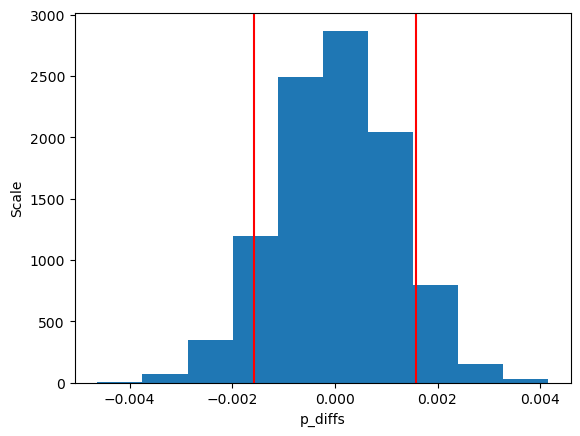

In [382]:
#plotting the difference 
null_vals = np.random.normal(np.mean(p_diffs) ,np.std(p_diffs) , 10000)
plt.hist(null_vals);
plt.xlabel('p_diffs')
plt.ylabel('Scale')
plt.axvline(x= obs_diff ,color = 'r' );
two_tailed = (0 - obs_diff) 
plt.axvline(x= two_tailed ,color = 'r' );

In [383]:
obs_diff

-0.0015782389853555567

In [384]:
(null_vals < obs_diff).mean()+(null_vals > two_tailed).mean()

0.1723

**observation**
p-value is greater than 0.05 --> 5% so we can't reject the null hypothesis that says that there is no diffeernce between the old and new page when it comes to conversions